In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import logging

module_path = os.path.abspath(os.path.join("../../.."))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from pathlib import Path

import torch
import torch.utils.data
from torchvision import transforms, datasets
import numpy as np
"""import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})"""
import matplotlib.pyplot as plt

import pvi
from pvi.models import ClassificationBNNLocalRepam
from pvi.clients import Client
from pvi.servers import SequentialServer
from pvi.servers import SynchronousServer
from pvi.distributions import MeanFieldGaussianDistribution, MeanFieldGaussianFactor
from pvi.utils.training_utils import EarlyStopping

In [2]:
data_dir = Path("/Users/terjemildner/Desktop/data")
cache_dir = Path("/Users/terjemildner/Desktop/PVI-main/experiments/fekmnist")

## Define various functions for splitting data and recording performance metrics.

In [3]:
# Data splitting functions.
def homogeneous_split(data, num_clients=100, seed=42):
    # Set numpy's random seed.
    np.random.seed(seed)
    
    perm = np.random.permutation(len(data["x"]))
    client_data = []
    for i in range(num_clients):
        client_idx = perm[i::num_clients]
        client_data.append({"x": data["x"][client_idx], "y": data["y"][client_idx]})
    
    return client_data

def heterogeneous_split(data, num_clients=100):
    # Set numpy's random seed.
    listed = np.argsort(data["y"])

    sorted_x = data["x"][listed[::1]]
    sorted_y = data["y"][listed[::1]]
    
    l = len(data["y"])
    client_size = int(np.ceil(l/num_clients))
    
    client_data = []
    
    for i in range(num_clients):        
        client_data.append({"x": sorted_x[i*client_size:(i+1)*client_size], 
                            "y": sorted_y[i*client_size:(i+1)*client_size]})
    
    return client_data


# Performance metric function. Why is the batch size 512 when the split gives 600? => Mini batches?
def performance_metrics(client, data, batch_size=512):
    dataset = torch.utils.data.TensorDataset(data["x"], data["y"])
    loader = torch.utils.data.DataLoader(dataset, batch_size=512, shuffle=False)
    
    device = client.config["device"]
    
    if device == "cuda":
        loader.pin_memory = True
        
    preds, mlls = [], []
    for (x_batch, y_batch) in loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        pp = client.model_predict(x_batch)
        preds.append(pp.component_distribution.probs.mean(1).cpu())
        mlls.append(pp.log_prob(y_batch).cpu())
        
    mll = torch.cat(mlls).mean()
    preds = torch.cat(preds)
    acc = sum(torch.argmax(preds, dim=-1) == loader.dataset.tensors[1]) / len(
        loader.dataset.tensors[1]
    )
    
    return {"mll": mll, "acc": acc}

## Data preprocessing

In [4]:
transform_train = transforms.Compose([transforms.ToTensor()])
transform_test = transforms.Compose([transforms.ToTensor()])

train_set = torch.from_numpy(np.load("../../../../data/Kuzushiji_49/k49-train-imgs.npz")['arr_0'])
train_labels = torch.from_numpy(np.load("../../../../data/Kuzushiji_49/k49-train-labels.npz")['arr_0'])
test_set = torch.from_numpy(np.load("../../../../data/Kuzushiji_49/k49-test-imgs.npz")['arr_0'])
test_labels = torch.from_numpy(np.load("../../../../data/Kuzushiji_49/k49-test-labels.npz")['arr_0'])

In [5]:
train_data = {
    "x": ((train_set - 0) / 255).reshape(-1, 28 * 28),
    "y": train_labels,
}

test_data = {
    "x": ((test_set- 0) / 255).reshape(-1, 28 * 28),
    "y": test_labels,
}
print(f"Training Data Length: ", len(train_data["x"]))
print(f"Testing Data Length: ", len(test_data["x"]))

Training Data Length:  232365
Testing Data Length:  38547


In [6]:
nums = dict()
for i in range(49):
    nums.update({str(i):0})
nums_test = dict()
for i in range(49):
    nums_test.update({str(i):0})

In [7]:
for y in train_data["y"]:
    s = str(int(y))
    temp = nums[s] + 1

    nums.update({s:temp})

for y in test_data["y"]:
    s = str(int(y))
    temp = nums_test[s] + 1

    nums_test.update({s:temp})

In [10]:
nums

{'0': 6000,
 '1': 6000,
 '2': 6000,
 '3': 777,
 '4': 6000,
 '5': 6000,
 '6': 6000,
 '7': 6000,
 '8': 4714,
 '9': 6000,
 '10': 6000,
 '11': 6000,
 '12': 6000,
 '13': 4165,
 '14': 3867,
 '15': 6000,
 '16': 2565,
 '17': 6000,
 '18': 6000,
 '19': 6000,
 '20': 6000,
 '21': 6000,
 '22': 2063,
 '23': 2451,
 '24': 6000,
 '25': 6000,
 '26': 5132,
 '27': 6000,
 '28': 6000,
 '29': 1993,
 '30': 6000,
 '31': 3060,
 '32': 1718,
 '33': 3394,
 '34': 6000,
 '35': 6000,
 '36': 1598,
 '37': 6000,
 '38': 6000,
 '39': 6000,
 '40': 6000,
 '41': 6000,
 '42': 2139,
 '43': 2397,
 '44': 417,
 '45': 392,
 '46': 6000,
 '47': 6000,
 '48': 3523}

In [15]:
idx_45 = []
for i in range(232365):
    if train_data["y"][i] == 45:
        idx_45.append(i)

In [12]:
train_set2 = np.load("../../../../data/Kuzushiji_49/k49-train-imgs.npz")['arr_0']
train_labels2 = np.load("../../../../data/Kuzushiji_49/k49-train-labels.npz")['arr_0']

Index 130 with label tensor(45, dtype=torch.uint8)
Index 206 with label tensor(45, dtype=torch.uint8)
Index 444 with label tensor(45, dtype=torch.uint8)
Index 1284 with label tensor(45, dtype=torch.uint8)
Index 1719 with label tensor(45, dtype=torch.uint8)
Index 2577 with label tensor(45, dtype=torch.uint8)
Index 2735 with label tensor(45, dtype=torch.uint8)
Index 2865 with label tensor(45, dtype=torch.uint8)
Index 3319 with label tensor(45, dtype=torch.uint8)
Index 3411 with label tensor(45, dtype=torch.uint8)
Index 4557 with label tensor(45, dtype=torch.uint8)
Index 5062 with label tensor(45, dtype=torch.uint8)
Index 5839 with label tensor(45, dtype=torch.uint8)
Index 6432 with label tensor(45, dtype=torch.uint8)
Index 7152 with label tensor(45, dtype=torch.uint8)
Index 8431 with label tensor(45, dtype=torch.uint8)
Index 8740 with label tensor(45, dtype=torch.uint8)
Index 8960 with label tensor(45, dtype=torch.uint8)
Index 9062 with label tensor(45, dtype=torch.uint8)
Index 9800 with

/var/folders/6x/7wzwn4g54n38_8rfbfx611n00000gn/T/ipykernel_50348/1692733289.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(1,1))


Index 13468 with label tensor(45, dtype=torch.uint8)
Index 13615 with label tensor(45, dtype=torch.uint8)
Index 14876 with label tensor(45, dtype=torch.uint8)
Index 15308 with label tensor(45, dtype=torch.uint8)
Index 15430 with label tensor(45, dtype=torch.uint8)
Index 15483 with label tensor(45, dtype=torch.uint8)
Index 15784 with label tensor(45, dtype=torch.uint8)
Index 16060 with label tensor(45, dtype=torch.uint8)
Index 17971 with label tensor(45, dtype=torch.uint8)
Index 20247 with label tensor(45, dtype=torch.uint8)
Index 20690 with label tensor(45, dtype=torch.uint8)
Index 22508 with label tensor(45, dtype=torch.uint8)
Index 23287 with label tensor(45, dtype=torch.uint8)
Index 23846 with label tensor(45, dtype=torch.uint8)
Index 23906 with label tensor(45, dtype=torch.uint8)
Index 26094 with label tensor(45, dtype=torch.uint8)
Index 26249 with label tensor(45, dtype=torch.uint8)
Index 26377 with label tensor(45, dtype=torch.uint8)
Index 26885 with label tensor(45, dtype=torch.

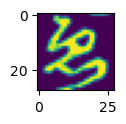

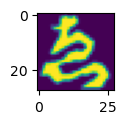

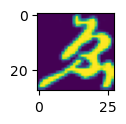

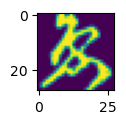

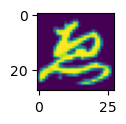

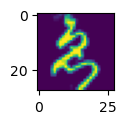

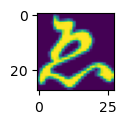

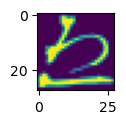

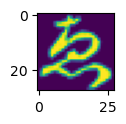

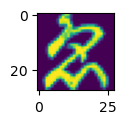

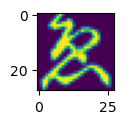

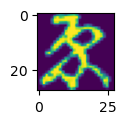

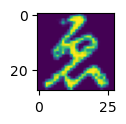

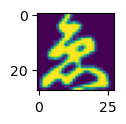

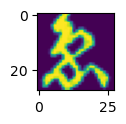

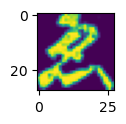

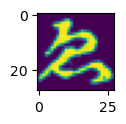

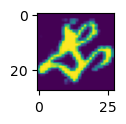

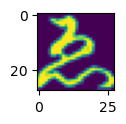

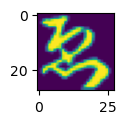

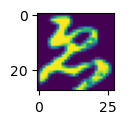

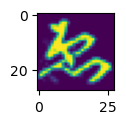

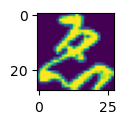

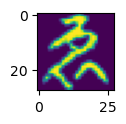

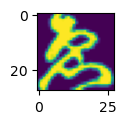

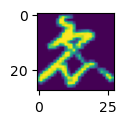

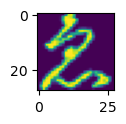

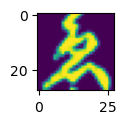

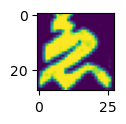

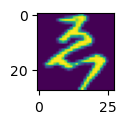

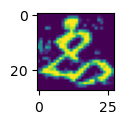

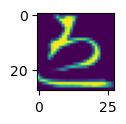

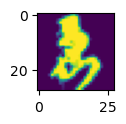

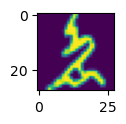

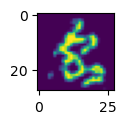

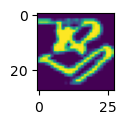

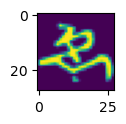

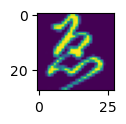

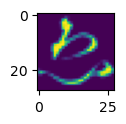

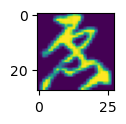

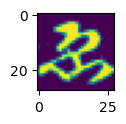

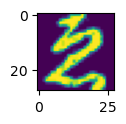

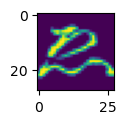

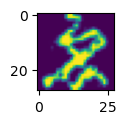

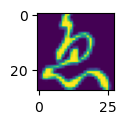

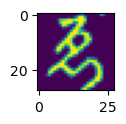

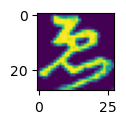

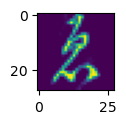

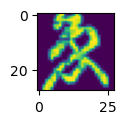

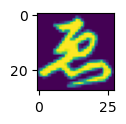

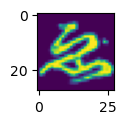

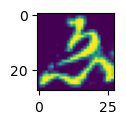

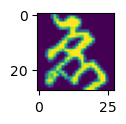

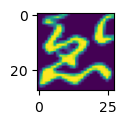

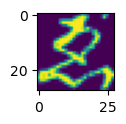

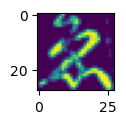

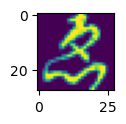

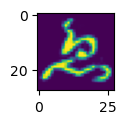

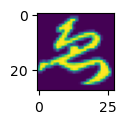

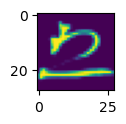

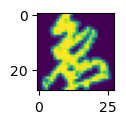

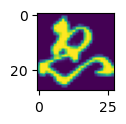

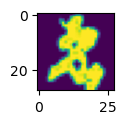

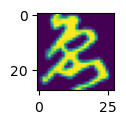

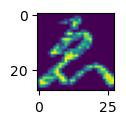

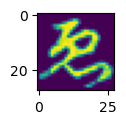

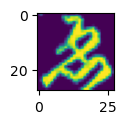

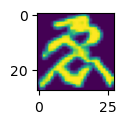

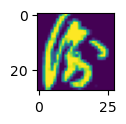

In [20]:
#print(train_set2[130])
for idx in idx_45:
    if idx < 50000:
        print(f"Index {idx} with label", train_data["y"][idx])
        plt.figure(figsize=(1,1))
        train_set2[idx].shape
        plt.imshow(train_set2[idx])
        
        #plt.set_title(train_labels2[130])
plt.show()

In [6]:
# Get client splits.
client_data = homogeneous_split(train_data, 10, seed=49)

## Define configuration for server and clients

In [7]:
model_config = {
    "input_dim": 784,
    "latent_dim": 100,
    "output_dim": 49,
    "num_layers": 1,
    "num_predictive_samples": 100,
    "prior_var": 1.0,
}

client_config = {
    "damping_factor": 1.0,
    "optimiser": "Adam",
    "optimiser_params": {"lr": 5e-4},
    "sigma_optimiser_params": {"lr": 5e-4},
    "early_stopping": EarlyStopping(25, score_name="elbo", stash_model=True),
    "performance_metrics": performance_metrics,
    "batch_size": 1024,
    "epochs": 2500,
    "print_epochs": np.inf,
    "num_elbo_samples": 10,
    "valid_factors": False,
    "device": "cpu",
    "init_var": 1e-3,
    "verbose": True,
    "divergence": "AR",
    "alpha": 0.75
}

server_config = {
    **client_config,
    #100
    "max_iterations": 30,
}

## Set up model etc.

In [8]:
device = server_config["device"]

model = ClassificationBNNLocalRepam(config=model_config)

# Initial parameters.
init_q_std_params = {
    "loc": torch.zeros(size=(model.num_parameters,)).to(device).uniform_(-0.1, 0.1),
    "scale": torch.ones(size=(model.num_parameters,)).to(device) 
    * client_config["init_var"] ** 0.5,
}

prior_std_params = {
    "loc": torch.zeros(size=(model.num_parameters,)).to(device),
    "scale": model_config["prior_var"] ** 0.5 
    * torch.ones(size=(model.num_parameters,)).to(device),
}

init_factor_nat_params = {
    "np1": torch.zeros(model.num_parameters).to(device),
    "np2": torch.zeros(model.num_parameters).to(device),
}

p = MeanFieldGaussianDistribution(
    std_params=prior_std_params, is_trainable=False
)
init_q = MeanFieldGaussianDistribution(
    std_params=init_q_std_params, is_trainable=False
)

clients = []
size_training = 0
for i in range(10):
    data_i = client_data[i]
    size_training += len(data_i["x"])
    t_i = MeanFieldGaussianFactor(nat_params=init_factor_nat_params)
    clients.append(
        Client(
            data=data_i,
            model=model,
            t=t_i,
            config=client_config,
            val_data=test_data
        )
    )    
server = SequentialServer(model=model, p=p, clients=clients, config=server_config, init_q=init_q, data=train_data, val_data=test_data)

## Run PGVI!

In [9]:
i = 0
while not server.should_stop():
    server.tick()

    # Obtain performance metrics.
    metrics = server.log["performance_metrics"][-1]
    print("Iterations: {}.".format(i))
    print("Time taken: {:.3f}.".format(metrics["time"]))
    print(
      "Test mll: {:.3f}. Test acc: {:.3f}.".format(
          metrics["val_mll"], metrics["val_acc"]
      )
    )
    print(
      "Train mll: {:.3f}. Train acc: {:.3f}.\n".format(
          metrics["train_mll"], metrics["train_acc"]
      )
    )
    i += 1

0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 0.
Time taken: 5248.336.
Test mll: -1.058. Test acc: 0.734.
Train mll: -0.561. Train acc: 0.850.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 1.
Time taken: 6788.390.
Test mll: -0.990. Test acc: 0.746.
Train mll: -0.518. Train acc: 0.864.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 2.
Time taken: 7986.605.
Test mll: -0.965. Test acc: 0.752.
Train mll: -0.499. Train acc: 0.869.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 3.
Time taken: 8967.797.
Test mll: -0.949. Test acc: 0.757.
Train mll: -0.489. Train acc: 0.873.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 4.
Time taken: 9899.413.
Test mll: -0.941. Test acc: 0.759.
Train mll: -0.483. Train acc: 0.874.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 5.
Time taken: 10731.173.
Test mll: -0.937. Test acc: 0.759.
Train mll: -0.477. Train acc: 0.876.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 6.
Time taken: 11473.650.
Test mll: -0.930. Test acc: 0.761.
Train mll: -0.474. Train acc: 0.877.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 7.
Time taken: 12325.783.
Test mll: -0.925. Test acc: 0.762.
Train mll: -0.469. Train acc: 0.878.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 8.
Time taken: 13083.248.
Test mll: -0.923. Test acc: 0.764.
Train mll: -0.466. Train acc: 0.880.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 9.
Time taken: 13656.515.
Test mll: -0.917. Test acc: 0.765.
Train mll: -0.464. Train acc: 0.880.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 10.
Time taken: 14365.259.
Test mll: -0.917. Test acc: 0.765.
Train mll: -0.461. Train acc: 0.881.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 11.
Time taken: 15102.845.
Test mll: -0.913. Test acc: 0.765.
Train mll: -0.458. Train acc: 0.881.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 12.
Time taken: 15707.200.
Test mll: -0.908. Test acc: 0.766.
Train mll: -0.457. Train acc: 0.882.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 13.
Time taken: 16317.549.
Test mll: -0.907. Test acc: 0.766.
Train mll: -0.455. Train acc: 0.882.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 14.
Time taken: 16972.080.
Test mll: -0.910. Test acc: 0.765.
Train mll: -0.458. Train acc: 0.881.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 15.
Time taken: 18111.608.
Test mll: -1.280. Test acc: 0.744.
Train mll: -0.569. Train acc: 0.861.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 16.
Time taken: 19477.017.
Test mll: -1.929. Test acc: 0.722.
Train mll: -0.819. Train acc: 0.846.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 17.
Time taken: 20791.110.
Test mll: -3.517. Test acc: 0.703.
Train mll: -1.505. Train acc: 0.832.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 18.
Time taken: 22707.426.
Test mll: -7.871. Test acc: 0.691.
Train mll: -3.521. Train acc: 0.820.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 19.
Time taken: 25617.792.
Test mll: -9.107. Test acc: 0.692.
Train mll: -3.938. Train acc: 0.825.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 20.
Time taken: 31353.412.
Test mll: -10.627. Test acc: 0.680.
Train mll: -4.614. Train acc: 0.814.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 21.
Time taken: 35785.833.
Test mll: -11.940. Test acc: 0.678.
Train mll: -5.077. Train acc: 0.814.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [88]:
train_acc = []
val_acc = []
times = []
comms = []
#train_acc.append(100.0)
#val_acc.append(100.0)
#times.append(1.0)
#comms.append(0.1)
for metrics in server.log["performance_metrics"]:
    train_acc.append(100-metrics["train_acc"]*100)
    val_acc.append(100-metrics["val_acc"]*100)
    times.append(metrics["time"]/25)
    comms.append(metrics["communications"])
plt.figure(figsize=(6,4))
plt.xscale("log")
plt.yscale("log")
plt.plot(times, val_acc, linewidth=1, label="PGVI")
plt.grid(visible=True)
plt.xlabel("Average Time")
plt.ylabel("% Testing Error")
plt.legend(loc="upper right", frameon=False)
plt.savefig("K-49_PGVI_sync.pgf", pad_inches=0)
plt.show()

/var/folders/6x/7wzwn4g54n38_8rfbfx611n00000gn/T/ipykernel_59497/347071954.py:19: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()
